In [1]:
import numpy as np
import pandas as pd
import json as json
from scipy import stats
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [2]:
from o_plot import opl # a small local package dedicated to this project

In [3]:
# Prepare the data

In [4]:
# loading the data
file_name = 'TE4AL2_data_new.json'
f = open(file_name)
All_data = json.load(f)
print(len(All_data))

98


## Note for the interpretation of the curves and definition of the statistical variables

The quantum state classifier (QSC) error rates $\widehat{r}_i$ in function of the number of experimental shots $n$ were determined for each highly entangled quantum state $\omega_i$ in the $\Omega$ set, with $i=1...m$.

The curves seen on the figures represents the mean of the QSC error rate $\widehat{r}_{mean}$ over the $m$ quantum states at each $n$ value.

This Monte Carlo simulation allowed to determine a safe shot number $n_s$ such that $\forall i\; \widehat{r}_i\le \epsilon_s$. The value of $\epsilon_s$ was set at 0.001.

$\widehat{r}_{max}$ is the maximal value observed among all the $\widehat{r}_i$ values for the determined  number of shots $n_s$.

Similarly, from the error curves stored in the data file, was computed the safe shot number $n_t$ such that $\widehat{r}_{mean}\le \epsilon_t$. The value of $\epsilon_t$ was set at 0.0005 after verifying that all $\widehat{r}_{mean}$ at $n_s$ were $\le \epsilon_s$ in the different experimental settings. 

Correspondance between variables names in the text and in the data base:

- $\widehat{r}_{mean}$: error_curve
- $n_s$: shots
- max ($\widehat{r}_i$) at $n_s$: shot_rate
- $\widehat{r}_{mean}$ at $n_s$: mns_rate
- $n_t$: m_shots
- $\widehat{r}_{mean}$ at $n_t$: m_shot_rate




In [5]:
# Calculate shot number 'm_shots' for mean error rate 'm_shot_rates' <= epsilon_t
len_data = len(All_data)
epsilon_t = 0.0005
window = 11
for i in range(len_data):            
    curve = np.array(All_data[i]['error_curve'])
    # filter the curve only for real devices:
    if All_data[i]['device']!="ideal_device":    
        curve = savgol_filter(curve,window,2) 
    # find the safe shot number:    
    len_c = len(curve)                               
    n_a = np.argmin(np.flip(curve)<=epsilon_t)+1                          
    if n_a == 1:
        n_a = np.nan
        m_r = np.nan
    else:
        m_r = curve[len_c-n_a+1]
    All_data[i]['min_r_shots'] = len_c-n_a
    All_data[i]['min_r'] = m_r

In [6]:
# find mean error rate at n_s
for i in range(len_data):
    i_shot = All_data[i]["shots"]
    if not np.isnan(i_shot):
        j = int(i_shot)-1        
        All_data[i]['mns_rate'] = All_data[i]['error_curve'][j]
    else:
        All_data[i]['mns_rate'] = np.nan

In [7]:
#defining the pandas data frame for statistics
df_All= pd.DataFrame(All_data,columns=['shot_rates','shots', 'device', 'fidelity',
                                        'mitigation','model','id_gates',
                                        'QV', 'metric','error_curve',
                                        'mns_rate','min_r_shots','min_r'])

# any shot number >= 488 indicates that the curve calculation 
# was ended after reaching n = 500, hence this data correction:
df_All.loc[df_All.shots>=488,"shots"]=np.nan

# add the variable neperian log of safe shot number: 
df_All['log_shots'] = np.log(df_All['shots'])
df_All['log_min_r_shots'] = np.log(df_All['min_r_shots'])

### Error rates in function of chosen $\epsilon_s$ and $\epsilon_t$

In [8]:
print("max mean error rate at n_s over all experiments =", round(max(df_All.mns_rate[:-2]),6), "vs epsilon_a =", epsilon_t)

max mean error rate at n_s over all experiments = 0.00048 vs epsilon_a = 0.0005


<AxesSubplot:ylabel='Frequency'>

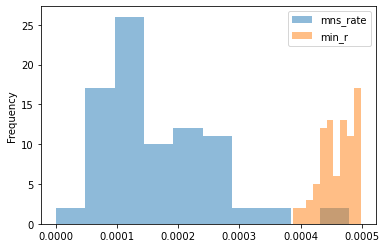

In [9]:
df_All.mns_rate[:-2].plot.hist(alpha=0.5, legend = True)
df_All.min_r[:-2].plot.hist(alpha=0.5, legend = True)

#### Comment:
- Histogram to the left: the observed $\widehat{r}_{mean}$ at $n_s$ is always less than 0.0005 for $\epsilon_s$ set at 0.001, and this for all tested experimental settings. 
- Histogram to the right: the $\widehat{r}_{mean}$ distribution is included in the 0.0004-0.0005 error rate interval when $\epsilon_t$ is set at 0.0005. 

# Statistical overview

For this section, an ordinary linear least square estimation is performed.
The dependent variables tested are $ln\;n_s$ (log_shots) and $ln\;n_t$ (log_min_r_shots)

In [10]:
stat_model = ols("log_shots ~  metric + mitigation + model + fidelity + QV + id_gates",
                 df_All.query("device != 'ideal_device' ")).fit()
print(stat_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_shots   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     93.31
Date:                Mon, 18 Jan 2021   Prob (F-statistic):           2.94e-33
Time:                        11:41:53   Log-Likelihood:                 36.730
No. Observations:                  84   AIC:                            -59.46
Df Residuals:                      77   BIC:                            -42.44
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 6.88

In [11]:
stat_model = ols("log_min_r_shots ~  metric + mitigation + model + fidelity + QV + id_gates",
                 df_All.query("device != 'ideal_device' ")).fit()
print(stat_model.summary())

                            OLS Regression Results                            
Dep. Variable:        log_min_r_shots   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     101.8
Date:                Mon, 18 Jan 2021   Prob (F-statistic):           1.54e-34
Time:                        11:41:53   Log-Likelihood:                 40.682
No. Observations:                  84   AIC:                            -67.36
Df Residuals:                      77   BIC:                            -50.35
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 6.45

#### Comments:

For the QSC, two different metrics were compared and at the end they gave the same output. For further analysis, the results obtained using the squared euclidean distance between distribution will be illustrated in this notebook, as it is more classical and strictly equivalent to the other classical Hellinger and Bhattacharyya distances. The Jensen-Shannon metric has however the theoretical advantage of being bayesian in nature and is therefore presented as an option for the result analysis.

Curves obtained for counts corrected by measurement error mitigation (MEM) are used in this presentation. MEM significantly reduces $n_s$ and  $n_t$. However, using counts distribution before MEM is presented as an option because they anticipate how the method could perform in devices with more qubits where obtaining the mitigation filter is a problem. 
 
The quantum measurement fidelity $f$ measured at the moment of the experimentations and the quantum volume $QV$ are negatively correlated with $ln\;n_s$ and $ln\;n_t$.

Introducing a delay time $\delta t$ of 256 identity gates between state creation and measurement significantly increased $ln\;n_s$ and $ln\;n_t$ . 


# Detailed statistical analysis



### Determine the options
Running sequentially these cells will end up with the main streaming options

In [12]:
# this for Jensen-Shannon metric 
s_metric = 'jensenshannon'
sm = np.array([96])
SAD=0
# ! will be unselected by running the next cell

In [13]:
# mainstream option for metric: squared euclidean distance
# skip this cell if you don't want this option
s_metric = 'sqeuclidean'
sm = np.array([97])
SAD=2   

In [14]:
# this for no mitigation
mit = 'no'
MIT=-4
# ! will be unselected by running the next cell

In [15]:
# mainstream option: this for measurement mitigation
# skip this cell if you don't want this option
mit = 'yes'
MIT=0

## 1. Compare distribution models


In [16]:
# select data according to the options
df_mod = df_All[df_All.mitigation == mit][df_All.metric == s_metric]

<ipython-input-16-af347b9ea33a>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_mod = df_All[df_All.mitigation == mit][df_All.metric == s_metric]


### A look at $n_s$ and  $n_t$

In [17]:
print("mitigation:",mit,"  metric:",s_metric )
df_mod.groupby('device')[['shots','min_r_shots']].describe(percentiles=[0.5])

mitigation: yes   metric: sqeuclidean


shots                                         min_r_shots  \
              count    mean        std    min    50%    max       count   
device                                                                    
ibmq_athens     4.0   40.75  10.078856   32.0   39.0   53.0         4.0   
ibmq_ourense    4.0   34.75   4.112988   30.0   34.5   40.0         4.0   
ibmq_santiago   4.0   38.75   8.180261   27.0   41.0   46.0         4.0   
ibmq_valencia   4.0   33.25   6.396614   25.0   34.0   40.0         4.0   
ibmq_vigo       4.0   32.50   7.724420   25.0   32.0   41.0         4.0   
ibmqx2          2.0  231.00  31.112698  209.0  231.0  253.0         2.0   

                                                       
                 mean        std    min    50%    max  
device                                                 
ibmq_athens     33.00  11.575837   23.0   31.0   47.0  
ibmq_ourense    27.25   4.991660   23.0   26.0   34.0  
ibmq_santiago   27.75   5.123475   22.0   28.0   33.0  
ibmq_valencia   26.00   4.966555   19.0   27.5   30.0  
ibmq_vigo       26.25   7.544314   19.0   25.5   35.0  
ibmqx2         158.50  26.162951  140.0  158.5  177.0

### Ideal vs empirical model: no state creation - measurements delay

<Figure size 432x288 with 0 Axes>

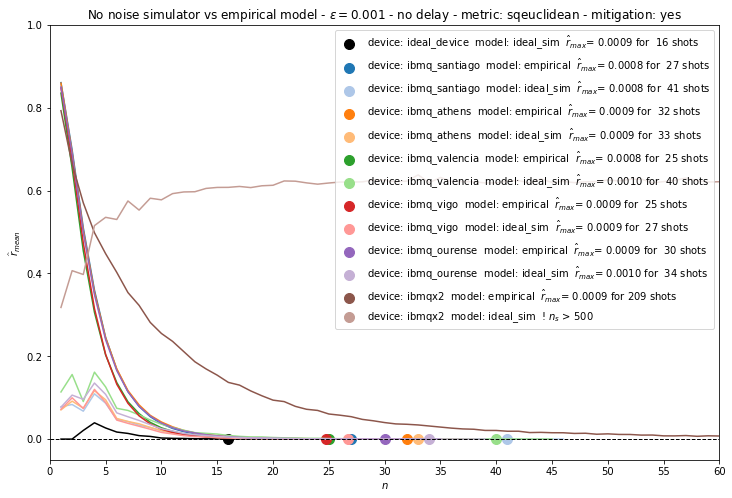

In [18]:
ADD=0+SAD+MIT
opl.plot_curves(All_data, np.append(sm,ADD+np.array([4,5,12,13,20,21,28,29,36,37,44,45])),                                                      
            "No noise simulator vs empirical model - $\epsilon=0.001$ - no delay",
            ["metric","mitigation"],
            ["device","model"], right_xlimit = 60)

#### Paired t-test and Wilcoxon test

In [19]:
for depvar in ['log_shots', 'log_min_r_shots']:
    print("mitigation:",mit,"  metric:",s_metric, "variable:", depvar)
    df_dep = df_mod.query("id_gates == 0.0").groupby(['model'])[depvar]
    print(df_dep.describe(percentiles=[0.5]),"\n")
    # no error rate curve obtained for ibmqx2 with the ideal model, hence this exclusion:
    df_emp=df_mod.query("model == 'empirical' & device != 'ibmqx2' & id_gates == 0.0 ")
    df_ide=df_mod.query("model == 'ideal_sim' & device != 'ibmqx2' & id_gates == 0.0")  #.reindex_like(df_emp,'nearest')
    # back to numpy arrays from pandas: 
    print("paired data")
    print(np.asarray(df_emp[depvar]))
    print(np.asarray(df_ide[depvar]),"\n")
    
    print(stats.ttest_rel(np.asarray(df_emp[depvar]),np.asarray(df_ide[depvar])))
    print(stats.wilcoxon(np.asarray(df_emp[depvar]),np.asarray(df_ide[depvar])),"\n")

mitigation: yes   metric: sqeuclidean variable: log_shots
           count      mean       std       min       50%       max
model                                                             
empirical    6.0  3.657143  0.831470  3.218876  3.348517  5.342334
ideal_sim    5.0  3.544231  0.168742  3.295837  3.526361  3.713572 

paired data
[3.29583687 3.4657359  3.21887582 3.21887582 3.40119738]
[3.71357207 3.49650756 3.68887945 3.29583687 3.52636052] 

Ttest_relResult(statistic=-2.4543723144511773, pvalue=0.07011454138286577)
WilcoxonResult(statistic=0.0, pvalue=0.0625) 

mitigation: yes   metric: sqeuclidean variable: log_min_r_shots
           count      mean       std       min       50%       max
model                                                             
empirical    6.0  3.372518  0.774839  2.944439  3.113268  4.941642
ideal_sim    5.0  3.188848  0.118889  3.044522  3.178054  3.367296 

paired data
[3.09104245 3.17805383 2.94443898 2.94443898 3.13549422]
[3.21887582 3.13549

### Ideal vs empirical model: with state creation - measurements delay of 256  id gates

<Figure size 432x288 with 0 Axes>

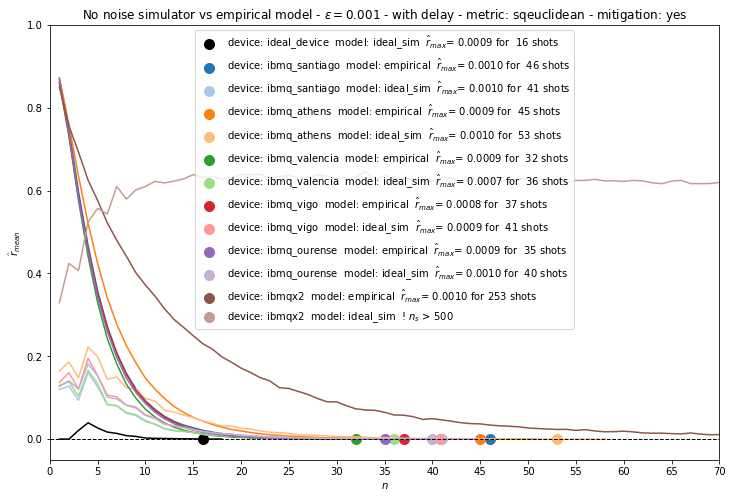

In [20]:
ADD=48+SAD+MIT
opl.plot_curves(All_data, np.append(sm,ADD+np.array([4,5,12,13,20,21,28,29,36,37,44,45])),                                                      
            "No noise simulator vs empirical model - $\epsilon=0.001$ - with delay",
            ["metric","mitigation"],
            ["device","model"], right_xlimit = 70)

#### Paired t-test and Wilcoxon test

In [21]:
for depvar in ['log_shots', 'log_min_r_shots']:
    print("mitigation:",mit,"  metric:",s_metric, "variable:", depvar)
    df_dep = df_mod.query("id_gates == 256.0").groupby(['model'])[depvar]
    print(df_dep.describe(percentiles=[0.5]),"\n")
    # no error rate curve obtained for ibmqx2 with the ideal model, hence this exclusion:
    df_emp=df_mod.query("model == 'empirical' & device != 'ibmqx2' & id_gates == 256.0 ")
    df_ide=df_mod.query("model == 'ideal_sim' & device != 'ibmqx2' & id_gates == 256.0")  #.reindex_like(df_emp,'nearest')
    # back to numpy arrays from pandas: 
    print("paired data")
    print(np.asarray(df_emp[depvar]))
    print(np.asarray(df_ide[depvar]),"\n")
    
    print(stats.ttest_rel(np.asarray(df_emp[depvar]),np.asarray(df_ide[depvar])))
    print(stats.wilcoxon(np.asarray(df_emp[depvar]),np.asarray(df_ide[depvar])),"\n")

mitigation: yes   metric: sqeuclidean variable: log_shots
           count      mean       std       min       50%       max
model                                                             
empirical    6.0  3.966783  0.780506  3.465736  3.708790  5.533389
ideal_sim    5.0  3.733967  0.142609  3.583519  3.713572  3.970292 

paired data
[3.8286414  3.80666249 3.4657359  3.61091791 3.55534806]
[3.71357207 3.97029191 3.58351894 3.71357207 3.68887945] 

Ttest_relResult(statistic=-1.6125187701705102, pvalue=0.1821439381961425)
WilcoxonResult(statistic=2.0, pvalue=0.1875) 

mitigation: yes   metric: sqeuclidean variable: log_min_r_shots
           count      mean       std       min       50%       max
model                                                             
empirical    6.0  3.716957  0.726971  3.258097  3.448852  5.176150
ideal_sim    5.0  3.553408  0.177637  3.401197  3.526361  3.850148 

paired data
[3.49650756 3.63758616 3.25809654 3.40119738 3.33220451]
[3.4339872  3.850147

### Pooling results obtained in circuit sets with and without creation-measurement delay

#### Paired t-test and Wilcoxon test

In [22]:
for depvar in ['log_shots', 'log_min_r_shots']:
    print("mitigation:",mit,"  metric:",s_metric, "variable:", depvar)
    df_dep = df_mod.groupby(['model'])[depvar]
    print(df_dep.describe(percentiles=[0.5]),"\n")
    # no error rate curve obtained for ibmqx2 with the ideal model, hence this exclusion:
    df_emp=df_mod.query("model == 'empirical' & device != 'ibmqx2' ")
    df_ide=df_mod.query("model == 'ideal_sim' & device != 'ibmqx2' ")  #.reindex_like(df_emp,'nearest')
    # back to numpy arrays from pandas:
    print("paired data")
    print(np.asarray(df_emp[depvar]))
    print(np.asarray(df_ide[depvar]),"\n")
    
    print(stats.ttest_rel(np.asarray(df_emp[depvar]),np.asarray(df_ide[depvar])))
    print(stats.wilcoxon(np.asarray(df_emp[depvar]),np.asarray(df_ide[depvar])),"\n")

mitigation: yes   metric: sqeuclidean variable: log_shots
           count      mean       std       min       50%       max
model                                                             
empirical   12.0  3.811963  0.785684  3.218876  3.510542  5.533389
ideal_sim   10.0  3.639099  0.178027  3.295837  3.688879  3.970292 

paired data
[3.29583687 3.4657359  3.21887582 3.21887582 3.40119738 3.8286414
 3.80666249 3.4657359  3.61091791 3.55534806]
[3.71357207 3.49650756 3.68887945 3.29583687 3.52636052 3.71357207
 3.97029191 3.58351894 3.71357207 3.68887945] 

Ttest_relResult(statistic=-2.7902399126324835, pvalue=0.02104558953298156)
WilcoxonResult(statistic=4.0, pvalue=0.013671875) 

mitigation: yes   metric: sqeuclidean variable: log_min_r_shots
           count      mean       std       min       50%       max
model                                                             
empirical   12.0  3.544738  0.738563  2.944439  3.295151  5.176150
ideal_sim   10.0  3.371128  0.239216  3.0

#### Statsmodel Ordinary Least Square (OLS)  Analysis

In [23]:
print("mitigation:",mit,"  metric:",s_metric )
stat_model = ols("log_shots ~  model + fidelity + model*fidelity",
                 df_mod).fit() 
print(stat_model.summary())

mitigation: yes   metric: sqeuclidean
                            OLS Regression Results                            
Dep. Variable:              log_shots   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     26.65
Date:                Mon, 18 Jan 2021   Prob (F-statistic):           7.69e-07
Time:                        11:41:56   Log-Likelihood:               -0.35340
No. Observations:                  22   AIC:                             8.707
Df Residuals:                      18   BIC:                             13.07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [24]:
print("mitigation:",mit,"  metric:",s_metric )
stat_model = ols("log_min_r_shots ~  model + fidelity  + model*fidelity",
                 df_mod).fit() 
print(stat_model.summary())

mitigation: yes   metric: sqeuclidean
                            OLS Regression Results                            
Dep. Variable:        log_min_r_shots   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     19.63
Date:                Mon, 18 Jan 2021   Prob (F-statistic):           6.61e-06
Time:                        11:41:56   Log-Likelihood:                -2.1333
No. Observations:                  22   AIC:                             12.27
Df Residuals:                      18   BIC:                             16.63
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

##### Comments:
For a particular experimental setting, the scarcity of the data doesn't allow conclusions.

For data pooled from experiments without and with $\delta t$, the classical paired t-test and Wilcoxon test favour an advantage of the front end empirical model (p<0.05).

The OLS model includes the variable $f$ wich represents hierarchically the devices. Indeed the interaction term $model$ x $f$  appears more judicious than a series of interaction terms $model$ x $device$. 

The OLS model confirms the front end empirical model advantage on the ideal device model for what concerns $ln\;n_s$ (p<0.05), but not for $ln\;n_t$ (NS).

Note: The $id\_gates$ variable could be dropped from the OLS model because the interaction $model$ x $id\_gates$ was weak. 

##  2. Error rate vs quantum readout fidelity and quantum volume

### 2.1 correlation between $\ln \; n_s$ for $\epsilon$ = 0.001 and  quantum readout error fidelity
Only the case with mitigation is studied here, as the case without mitigation lack of the data concerning the Yorktown device.

In [25]:
# restore mainstream option: mitigation
mit = 'yes'
MIT=0

#### A look at the error rate curves obtained using the front end empirical model

<Figure size 432x288 with 0 Axes>

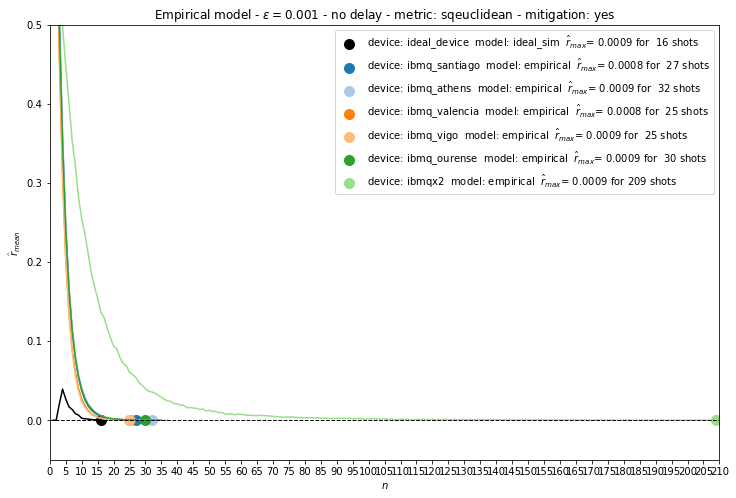

In [26]:
ADD=0+SAD+MIT
opl.plot_curves(All_data, np.append(sm,ADD+np.array([4,12,20,28,36,44])),                                                      
            "Empirical model - $\epsilon=0.001$ - no delay",
            ["metric","mitigation"],
            ["device","model"], right_xlimit = 210, top_ylimit = 0.5)

 #### Correlation  between $\ln \; n_s$ for $\epsilon$ = 0.001 and  quantum readout error fidelity

<Figure size 720x432 with 0 Axes>

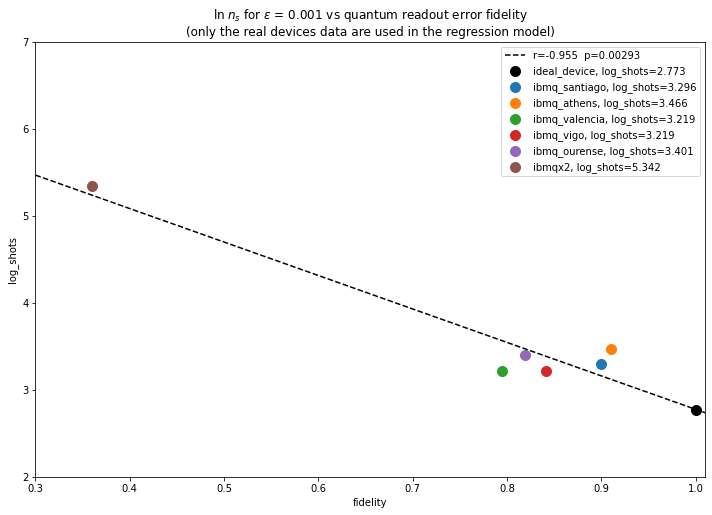

In [27]:
# rem: in this figure, the ideal device calculated value is shown
# but not included in the regression model
df_short = df_All.query("model == 'empirical' & id_gates == 0.0 " )
df_short = df_short[df_short.metric == s_metric]
# exclude ibmqx2 when no mitigation (no data)
if mit == "no":
    df_short = df_short[df_short.device != 'ibmqx2']
# here for adding the "ideal device" observation"
df_ideal= df_All.query("device == 'ideal_device' ")
df_ideal = df_ideal[df_ideal.metric == s_metric]  
df_short = df_short[df_short['mitigation']==mit]
tit_head = "$\ln \; n_s$ for $\epsilon$ = 0.001 vs "
tit_tail =  "(only the real devices data are used in the regression model)"
opl.plot_scatter(df_ideal.append(df_short),"fidelity",
     tit_head + "quantum readout error fidelity\n" +tit_tail, ydata='log_shots',
     left_xlimit = 0.1*np.floor(min(df_short.fidelity*10)), right_xlimit = 1.01,
     bottom_ylimit = np.floor(min(df_ideal.log_shots)),
     top_ylimit = 1+np.ceil(max(df_short.log_shots)))

In [28]:
print("mitigation:",mit,"  metric:",s_metric )
stat_model = ols("log_shots ~  fidelity",
                 df_mod.query("id_gates == 0.0 & model == 'empirical'")).fit() 
print(stat_model.summary())

mitigation: yes   metric: sqeuclidean
                            OLS Regression Results                            
Dep. Variable:              log_shots   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     41.91
Date:                Mon, 18 Jan 2021   Prob (F-statistic):            0.00293
Time:                        11:41:57   Log-Likelihood:                0.46186
No. Observations:                   6   AIC:                             3.076
Df Residuals:                       4   BIC:                             2.660
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     

C:\Users\decpi\Anaconda3\envs\QK20\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [29]:
# check: show that python linregress (see figure) and OLS stat_model (table) agree
print("r calculated in the OLS model:", round(np.sqrt(stat_model.rsquared),3)) 
print("to be compared to the value of r reportted in the figure legend")

r calculated in the OLS model: 0.955
to be compared to the value of r reportted in the figure legend


#### calculate the expected value of n_s for a theoretical fidelity equal to 1.0 

In [30]:
# calculate the expected value of n_s for a theoretical fidelity equal to 1.0
# to be compared to the oracle derived value for an ideal device: n_s = 16  
id_fidelity = 1.0
alpha, beta = stat_model.params
n_ideal = np.exp(alpha+beta*id_fidelity)
print("extrapolated value of n_s at fidelity = 1.0:", n_ideal)
print("to be compared to the oracle derived value for an ideal device: n_s = 16")

extrapolated value of n_s at fidelity = 1.0: 16.043394359562313
to be compared to the oracle derived value for an ideal device: n_s = 16


#### Comments:

A significant correlation was found experimentally between $\ln \; n_s$ and $f$.

The graph here concerns the strongest correlation, which was observed in the case of applying MEM and the empirical model, with no delay introduced between state creation and measurement.
    
Interestingly, the theoretical $n_s$ value for an ideal device and the $n_s$ value for $f$ = 1.0 extrapolated from the $\ln \; n_s$ - $f$ correlation are quiet similar (16 vs 16.04).

This adds arguments for using the logarithm of shot numbers as independant variables in this statistical analysis.
